## Time-Series Forecasting: Predicting Paypal Stock Price Using A Deep Learning Model

**Long Short-Term Memory (LSTM)** network is a type of recurrent neural network (RNN) capable of learning order dependence in sequence prediction problems. Because LSTM models can store data throughout time, they are good tools for time-series forecasting.

In [29]:
# Import useful libraries
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader import data as pdr
import seaborn as sns
import matplotlib.pyplot as plt

### Preprocess Data

In [30]:
# import the data
yf.pdr_override()

pypl_data = pdr.get_data_yahoo("PYPL", start="2018-01-01", end="2023-06-20")
pypl_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,74.235001,74.500000,73.430000,73.839996,73.839996,7296500
2018-01-03,74.300003,76.849998,74.050003,76.750000,76.750000,9945400
2018-01-04,77.330002,77.929001,76.260002,76.730003,76.730003,8650000
2018-01-05,77.110001,78.930000,77.010002,78.699997,78.699997,11822100
2018-01-08,78.699997,79.180000,77.773003,79.050003,79.050003,7963600


In [31]:
pypl_data.shape

(1374, 6)

Text(0.5, 1.0, 'History of Closing price')

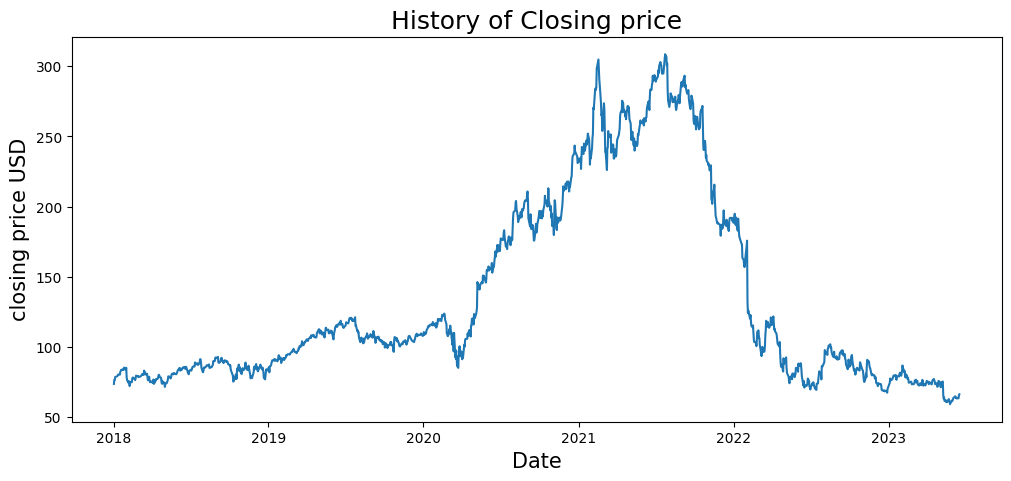

In [32]:
plt.figure(figsize=(12,5))
sns.lineplot(x= pypl_data.index,y=pypl_data['Close'])
plt.xlabel('Date', fontsize=15)
plt.ylabel('closing price USD',fontsize=15)
plt.title('History of Closing price',fontsize=18)

In [33]:
# Split the data set into Train and Test
# with 75% of data as training set
data_train = pypl_data[:1030]
data_test = pypl_data[1030:]

In [34]:
# Save data as csv
data_train.to_csv('data_train.csv')
data_test.to_csv('data_test.csv')

In [35]:
# We use the date and close price values for our model training
close_data= pypl_data.iloc[: , 3:4]
close_data.head()

,Close
Date,
2018-01-02,73.839996
2018-01-03,76.750000
2018-01-04,76.730003
2018-01-05,78.699997
2018-01-08,79.050003


In [36]:
training_set = close_data.iloc[:1030,:].values
test_set = close_data.iloc[1030:,:].values

In [37]:
# Normalize the data for better performance
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
training_set_scaled= sc.fit_transform(training_set)

In [38]:
# Create a data structure with shorter sequence

def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len
    return np.array([data[i:(i+seq_len),0] for i in range(n_seq)]), np.array([data[i+seq_len,0] for i in range(n_seq)])

X_train, y_train= split_into_sequences(training_set_scaled, 60)

In [39]:
X_train[0],y_train[0]

(array([0.00891044, 0.02119931, 0.02111487, 0.0294341 , 0.03091216,
        0.03150338, 0.03226351, 0.03386823, 0.03720438, 0.03669761,
        0.04535472, 0.04733952, 0.05114017, 0.05173142, 0.05270269,
        0.0505912 , 0.05325166, 0.05793916, 0.05312498, 0.05088681,
        0.05739019, 0.02816722, 0.02043917, 0.01256334, 0.01668073,
        0.01630065, 0.00249154, 0.01275336, 0.01499154, 0.01368242,
        0.02339524, 0.0277238 , 0.02804054, 0.02250842, 0.02018581,
        0.02521112, 0.03361486, 0.03217903, 0.03264356, 0.03243243,
        0.02918073, 0.03015203, 0.03099661, 0.0316723 , 0.03289693,
        0.034375  , 0.03792228, 0.03745775, 0.03576855, 0.048902  ,
        0.04577701, 0.04404561, 0.03619088, 0.03855573, 0.03931587,
        0.02884288, 0.0198902 , 0.03048984, 0.01934119, 0.01406248]),
 0.01748310586858004)

In [40]:
X_train.shape, y_train.shape

((970, 60), (970,))

In [41]:
# reshape the data into the following format (values, time-steps, 1 dimensional output)
X_train= np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_train.shape

(970, 60, 1)

### Build the LSTM Model

In [42]:
# Use Keras libraries and packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [43]:
# Build an RNN model with 4 layers

# Initialize the RNN
model= Sequential()

# Adding first LSTM layer and Dropout regularization
model.add(LSTM(units=100,return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(rate=0.2))

# Adding second LSTM layer and Dropout regularization
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(rate=0.2))

# Adding third LSTM layer and Dropout regularization
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(rate=0.2))

# Adding fourth LSTM layer and Dropout regularization
model.add(LSTM(units=100))
model.add(Dropout(rate=0.2))

# Adding the Output Layer
model.add(Dense(units=1))

# Compiling the Model with loss function of mean_square_error
model.compile(loss='mean_squared_error', optimizer='adam')

In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 100)           40800     
                                                                 
 dropout_8 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_9 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_9 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 100)           80400     
                                                                 
 dropout_10 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_11 (LSTM)              (None, 100)              

In [45]:
# Fitting the model
history=model.fit(X_train,y_train,epochs=100,batch_size=50)

Epoch 1/100
20/20 [==============================] - 7s 21ms/step - loss: 0.0530
Epoch 2/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0074
Epoch 3/100
20/20 [==============================] - 0s 14ms/step - loss: 0.0044
Epoch 4/100
20/20 [==============================] - 0s 14ms/step - loss: 0.0045
Epoch 5/100
20/20 [==============================] - 0s 14ms/step - loss: 0.0044
Epoch 6/100
20/20 [==============================] - 0s 14ms/step - loss: 0.0035
Epoch 7/100
20/20 [==============================] - 0s 14ms/step - loss: 0.0038
Epoch 8/100
20/20 [==============================] - 0s 18ms/step - loss: 0.0037
Epoch 9/100
20/20 [==============================] - 0s 20ms/step - loss: 0.0036
Epoch 10/100
20/20 [==============================] - 0s 19ms/step - loss: 0.0043
Epoch 11/100
20/20 [==============================] - 0s 19ms/step - loss: 0.0038
Epoch 12/100
20/20 [==============================] - 0s 19ms/step - loss: 0.0037
Epoch 13/100
20/20 [=====

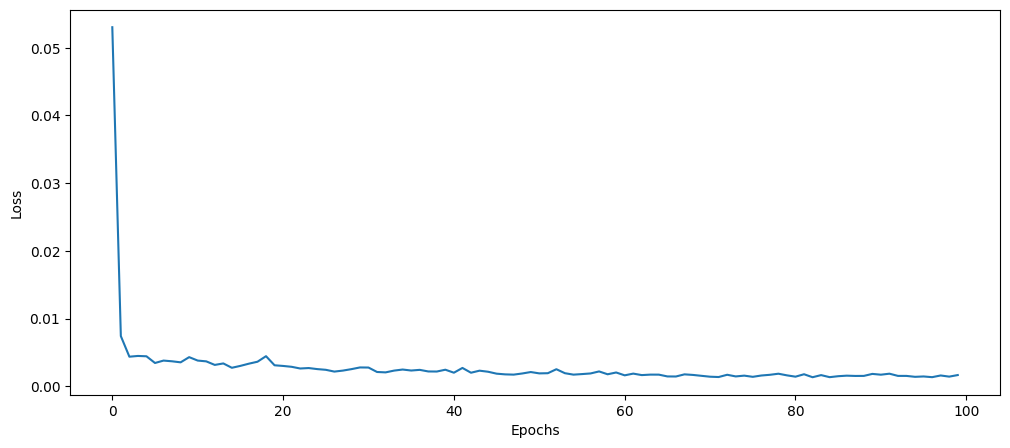

In [46]:
# Evaluating The Model
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

###Predict the Data

In [47]:
# Load train and est data set
train_data= pd.read_csv('data_train.csv')
test_data= pd.read_csv('data_test.csv')

In [48]:
real_stock_price = test_data.iloc[:, 3:4].values

In [54]:
real_stock_price.shape

(344, 1)

In [55]:
# Concatenate and Scale
total_data= pd.concat([train_data['Close'], test_data['Close']],  axis=0)
inputs= total_data[len(total_data)-len(test_data)-60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(60, 404):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [56]:
X_test.shape

(344, 60, 1)

In [57]:
# Predict the model
predicted_stock_price = model.predict(X_test)

11/11 [==============================] - 0s 10ms/step


In [58]:
# Inverse the scaling
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

### Visualize the Result

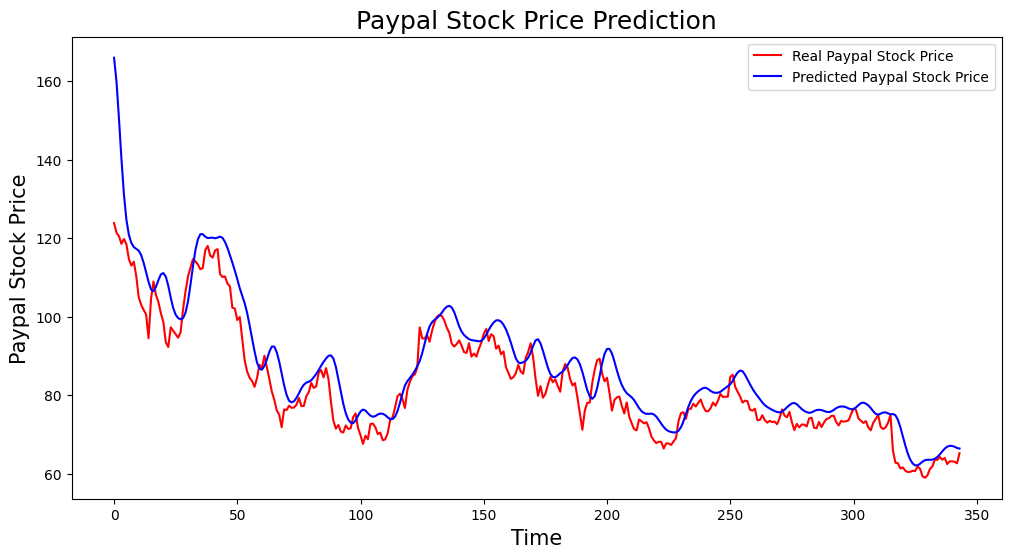

In [59]:
plt.figure(figsize=(12,6))
plt.plot(real_stock_price, color='Red', label='Real Paypal Stock Price')
plt.plot(predicted_stock_price, color='Blue', label='Predicted Paypal Stock Price')
plt.title('Paypal Stock Price Prediction',fontsize=18)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Paypal Stock Price',fontsize=15)
plt.legend()
plt.show()